In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
from torch.utils.data import DataLoader, RandomSampler
from transformers import pipeline, AdamW
from transformers import BertTokenizer, BertForSequenceClassification

plt.style.use('ggplot')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    file_path = "../data/processed/"
    file_file = f"manual_class-tweets.csv"    
    df_agrupado = pd.read_csv(f"{file_path}{file_file}", sep=";", encoding="utf-8")
    
except Exception as e:
    print(e)
    
    # Planilhas com classificação manual
    df_dani = pd.read_excel('../data/manual_eval_tweets.xlsx', sheet_name='Daniela Nomura')
    df_dagna = pd.read_excel('../data/manual_eval_tweets.xlsx', sheet_name='Dagna')
    df_jose = pd.read_excel('../data/manual_eval_tweets.xlsx', sheet_name='José Valdeir')
    df_bruno = pd.read_excel('../data/manual_eval_tweets.xlsx', sheet_name='Bruno')
    df_thiago = pd.read_excel('../data/manual_eval_tweets.xlsx', sheet_name='Thiago')
    
    # Agrupando dataframes com classificação manual para ajuste fino
    df_agrupado = pd.concat([df_dani, df_dagna, df_jose, df_bruno, df_thiago])

    # Salvando arquivo para não ter que processar novamente
    df_agrupado.to_csv(f"{file_path}{file_file}", sep=";", encoding="utf-8", index=False)
    
df_ajuste = df_agrupado[['content', 'classe_manual']]    

read_csv() got an unexpected keyword argument 'index'


## Utilizando dados classificados manualmente

In [3]:
classifier = pipeline(
    "sentiment-analysis",
    model='ruanchaves/bert-base-portuguese-cased-hatebr',
    device=torch.cuda.current_device(),
)

In [4]:
%%time
results = df_ajuste['content'].apply(lambda x: classifier(x))

CPU times: user 11.5 s, sys: 1.41 s, total: 12.9 s
Wall time: 12.9 s


In [5]:
# Separando rotulo e score
labels = [result[0]['label'] for result in results]
scores = [result[0]['score'] for result in results]

# Criando colunas com rótulos e score no dataframe de ajuste
df_ajuste['classif_sem_ajuste'] = labels
df_ajuste['score_sem_ajuste'] = scores

df_ajuste.iloc[:, [0,1,2]]

,content,classe_manual,classif_sem_ajuste
0,Não acredite nesses fantasmas que querem distr...,False,True
1,"Pelo jeito, a carruagem virou abóbora antes da...",False,True
2,"@rosana Gente, só eu não vi? Desculpa a vergon...",False,True
3,@victorpvianna Crime,False,False
4,O Alexandre tá passando pano?,False,True
...,...,...,...
396,@carteiroreaca 👏👏👏👏🇧🇷🇧🇷,False,False
397,@carteiroreaca E se fosse vc no lugar do Dougl...,False,False
398,"@carteiroreaca @carteiroreaca ,como eu te prom...",False,False
399,"@carteiroreaca É sensato da sua parte, deputado.",False,False


In [6]:
# Criando coluna adicional para não ter perigo de errar e ter que fazer a classificação novamente
df_ajuste['classe_manual_2'] = df_ajuste['classe_manual']

# Respostas com classificação divergente
df_ajuste['classe_manual'].value_counts()

False         1035
FALSO          635
True           170
VERDADEIRO     160
Name: classe_manual, dtype: int64

In [7]:
# Padronizando respostas
df_ajuste['classe_manual_2'] = df_ajuste['classe_manual_2'].replace('FALSO', False)
df_ajuste['classe_manual_2'] = df_ajuste['classe_manual_2'].replace('VERDADEIRO', True)

# Verificando resultados da classificação manual e do modelo antes do ajuste fino
print(df_ajuste['classe_manual_2'].value_counts())
print(df_ajuste['classif_sem_ajuste'].value_counts())

False    1670
True      330
Name: classe_manual_2, dtype: int64
False    1463
True      537
Name: classif_sem_ajuste, dtype: int64


In [8]:
# Verificando métricas do modelo pré-treinado antes do ajuste fino
acuracia_pre_ajuste = accuracy_score(df_ajuste['classe_manual_2'], df_ajuste['classif_sem_ajuste'])
precision_pre_ajuste = precision_score(df_ajuste['classe_manual_2'], df_ajuste['classif_sem_ajuste'])
recall_pre_ajuste = recall_score(df_ajuste['classe_manual_2'], df_ajuste['classif_sem_ajuste'])
f1_pre_ajuste = f1_score(df_ajuste['classe_manual_2'], df_ajuste['classif_sem_ajuste'])

# Criando variáveis para comparar os resultados
result_metrics = []
result_metrics.append({
    'name': 'Pre fine-tuning',
    'training_params': '',
    'training_results': '',
    'model': classifier.model,
    'accuracy': acuracia_pre_ajuste.round(3),
    'precision': precision_pre_ajuste.round(3),
    'recall': recall_pre_ajuste.round(3),
    'f1_score': f1_pre_ajuste.round(3),
    'date': datetime.now(),
})

# Ajuste fino do modelo escolhido

In [9]:
# Verificando dataframe que será usado para ajuste
df_ajuste

,content,classe_manual,classif_sem_ajuste,score_sem_ajuste,classe_manual_2
0,Não acredite nesses fantasmas que querem distr...,False,True,0.999933,False
1,"Pelo jeito, a carruagem virou abóbora antes da...",False,True,0.999743,False
2,"@rosana Gente, só eu não vi? Desculpa a vergon...",False,True,0.999871,False
3,@victorpvianna Crime,False,False,0.956910,False
4,O Alexandre tá passando pano?,False,True,0.994142,False
...,...,...,...,...,...
396,@carteiroreaca 👏👏👏👏🇧🇷🇧🇷,False,False,0.999860,False
397,@carteiroreaca E se fosse vc no lugar do Dougl...,False,False,0.999962,False
398,"@carteiroreaca @carteiroreaca ,como eu te prom...",False,False,0.999977,False
399,"@carteiroreaca É sensato da sua parte, deputado.",False,False,0.999978,False


In [10]:
# Convertendo classificação em binário para o formato adequado para ajuste fino do modelo
df_ajuste['classe_manual_bin'] = df_ajuste['classe_manual_2'].astype(int)
df_ajuste['classif_sem_ajuste_bin'] = df_ajuste['classif_sem_ajuste'].astype(int)

# Verificando a conversão
print(df_ajuste[['classe_manual_bin', 'classe_manual_2']].value_counts())
print(df_ajuste[['classif_sem_ajuste', 'classif_sem_ajuste_bin']].value_counts())

classe_manual_bin  classe_manual_2
0                  False              1670
1                  True                330
dtype: int64
classif_sem_ajuste  classif_sem_ajuste_bin
False               0                         1463
True                1                          537
dtype: int64


In [11]:
# Fazendo divisão entre treino e teste
X = df_ajuste['content']
Y = df_ajuste['classe_manual_bin']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.3, stratify = Y, random_state=42
)

# Fazendo divisão entre treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.3, stratify = y_train, random_state=42
)

# Verificando dimensões
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((980,), (420,), (600,), (980,), (420,), (600,))

In [12]:
# Carregando modelo BERT pré-treinado
model_name = "ruanchaves/bert-base-portuguese-cased-hatebr"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 rótulos: 'False', 'True'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [13]:
# Convertendo dados para formato adequado e separando conjunto de treino e validação.
train_texts = X_train.to_list()  # Lista of tweet para treino
train_labels = y_train.to_list() # Lista of rótulos (0 ou 1) para treino

val_texts = X_val.to_list()    # Lista of tweet para validação
val_labels = y_val.to_list()   # Lista of rótulos (0 ou 1) para validação

# Tokenizar e converter dados para formato adequado para o BERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Convertendo dados para tensores do PyTorch
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings.input_ids),
    torch.tensor(train_encodings.attention_mask),
    torch.tensor(train_labels)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings.input_ids),
    torch.tensor(val_encodings.attention_mask),
    torch.tensor(val_labels)
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [74]:
# Definindo parâmetros do modelo
training_params = {
    'train_batch_size': 16,
    'val_batch_size': 32,
    # 'lr': 2e-5,
    'lr': 3e-6,
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'num_epochs': 20,
}

# Definindo o DataLoader para batching
train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=training_params['train_batch_size']
)

val_dataloader = DataLoader(
    val_dataset, 
    sampler=RandomSampler(val_dataset), 
    batch_size=training_params['val_batch_size']
)

# Define otimizador e loss function. 
# lr = 2e-5
optimizer = AdamW(
    model.parameters(), 
    lr=training_params['lr']
)
loss_fn = training_params['loss_fn']
num_epochs = training_params['num_epochs']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

metrics = {
    'training_params': training_params
}
print(metrics)

{'training_params': {'train_batch_size': 16, 'val_batch_size': 32, 'lr': 3e-06, 'loss_fn': CrossEntropyLoss(), 'num_epochs': 20}}


In [75]:
%%time
# Loop de ajuste fino
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validação
    model.eval()
    val_accuracy = 0
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            val_accuracy += torch.sum(preds == labels).item()

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataset)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train loss: {avg_train_loss:.4f}, Validation loss: {avg_val_loss:.4f}")
    print(f"Validation accuracy: {avg_val_accuracy:.4f}")

t = datetime.now().strftime('%H:%m:%S')
metrics['name'] = f'Fine-tune: {t}'
metrics['training_results'] = f'{avg_train_loss=:.4f}, {avg_val_loss=:.4f}, {avg_val_accuracy=:.4f}, {num_epochs=}'

Epoch 1/20
Train loss: 0.1074, Validation loss: 0.2993
Validation accuracy: 0.8976
Epoch 2/20
Train loss: 0.1030, Validation loss: 0.3405
Validation accuracy: 0.8976
Epoch 3/20
Train loss: 0.0717, Validation loss: 0.3783
Validation accuracy: 0.8976
Epoch 4/20
Train loss: 0.0826, Validation loss: 0.3316
Validation accuracy: 0.9000
Epoch 5/20
Train loss: 0.0537, Validation loss: 0.6054
Validation accuracy: 0.8976
Epoch 6/20
Train loss: 0.0537, Validation loss: 0.3640
Validation accuracy: 0.8952
Epoch 7/20
Train loss: 0.0459, Validation loss: 0.3827
Validation accuracy: 0.8929
Epoch 8/20
Train loss: 0.0505, Validation loss: 0.3814
Validation accuracy: 0.8952
Epoch 9/20
Train loss: 0.0354, Validation loss: 0.4054
Validation accuracy: 0.8929
Epoch 10/20
Train loss: 0.0400, Validation loss: 0.4080
Validation accuracy: 0.8952
Epoch 11/20
Train loss: 0.0299, Validation loss: 0.4543
Validation accuracy: 0.8929
Epoch 12/20
Train loss: 0.0312, Validation loss: 0.4860
Validation accuracy: 0.8952
E

In [76]:
# Salvando o modelo. No meu caso foi salvo no ambiente virtual
output_dir = "./fine_tuned_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json')

## Classificando com o modelo refinado

In [77]:
# Diretório onde modelo foi salvo
model_path = "./fine_tuned_model"

# Carregando tokenizer e modelo
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Escolhendo o dispositivo adequado (CPU or GPU) caso haja mais que um disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criando pipeline customizado de analise de sentimento
# OBS: possível instanciar o modelo sem o tokenizer e device
classifier = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=torch.cuda.current_device()
)

metrics['model'] = classifier.model

In [78]:
%%time
# Armazenando resultados da classificação
results = X_test.apply(lambda x: classifier(x))

CPU times: user 4.42 s, sys: 545 ms, total: 4.96 s
Wall time: 4.97 s


In [79]:
# Separando rotulo e score
labels_pos_ajuste = [result[0]['label'] for result in results]
scores_pos_ajuste = [result[0]['score'] for result in results]

# Criando dataframe com tweets, classificação manual e do modelo pós ajuste fino
df_pos_ajuste = pd.DataFrame({'tweets': X_test, 'classe_manual_bin': y_test, 'classe_ajuste_fino': labels_pos_ajuste})

# Convertendo resultados binários e booleanos
df_pos_ajuste['classe_manual'] = df_pos_ajuste['classe_manual_bin'].apply(lambda x: False if x == 0 else True)

# Verificando dataframe
df_pos_ajuste

,tweets,classe_manual_bin,classe_ajuste_fino,classe_manual
310,"Nesta reta final, conto com seu apoio. A Ana P...",0,False,False
247,"@andreawerner_ Totalmente, lendo cola na mão....",0,False,False
353,"@andreawerner_ Como vc não é de MG, só tenho c...",0,False,False
272,@andreawerner_ @augustodeAB 4004\nFora isso Má...,0,False,False
341,"@carteiroreaca Vê se vcs parem de brigar pqp ,...",0,False,False
...,...,...,...,...
238,"@carteiroreaca Se depender dos aposentados, pe...",0,False,False
245,@carteiroreaca TMJ Gil!,0,False,False
207,@carteiroreaca @nikolas_dm @jairbolsonaro Verd...,1,False,True
231,@carteiroreaca @neymarjr BOLSONARO EM SANTOS!!...,0,True,False


In [80]:
# Verificando performance do modelo pré-treinado pós ajuste fino 
acuracia_pos_ajuste = accuracy_score(df_pos_ajuste['classe_manual'], df_pos_ajuste['classe_ajuste_fino'])
precision_pos_ajuste = precision_score(df_pos_ajuste['classe_manual'], df_pos_ajuste['classe_ajuste_fino'])
recall_pos_ajuste = recall_score(df_pos_ajuste['classe_manual'], df_pos_ajuste['classe_ajuste_fino'])
f1_pos_ajuste = f1_score(df_pos_ajuste['classe_manual'], df_pos_ajuste['classe_ajuste_fino'])

metrics['accuracy'] = acuracia_pos_ajuste.round(3)
metrics['precision'] = precision_pos_ajuste.round(3)
metrics['recall'] = recall_pos_ajuste.round(3)
metrics['f1_score'] = f1_pos_ajuste.round(3)
metrics['date'] = datetime.now()
result_metrics.append(metrics)

## Visualizando impacto do treinamento

In [81]:
# Cria DataFrame para visualização
df_results = pd.DataFrame(result_metrics)
df_results[['name', 'accuracy', 'precision', 'recall', 'f1_score', 'training_params', 'date']]

,name,accuracy,precision,recall,f1_score,training_params,date
0,Pre fine-tuning,0.824,0.480,0.782,0.595,,2023-07-25 18:32:08.349185
1,Fine-tune: 18:07:30,0.848,0.526,0.808,0.637,"{'train_batch_size': 16, 'val_batch_size': 32,...",2023-07-25 18:39:12.876997
2,Fine-tune: 18:07:39,0.905,0.728,0.677,0.702,"{'train_batch_size': 16, 'val_batch_size': 32,...",2023-07-25 18:47:22.871180
3,Fine-tune: 18:07:46,0.890,0.654,0.707,0.680,"{'train_batch_size': 16, 'val_batch_size': 32,...",2023-07-25 18:57:59.799651


In [90]:
print(df_results.iloc[1]['training_params'])
print(df_results.iloc[2]['training_params'])
print(df_results.iloc[3]['training_params'])

{'train_batch_size': 16, 'val_batch_size': 32, 'lr': 3e-06, 'loss_fn': CrossEntropyLoss(), 'num_epochs': 10}
{'train_batch_size': 16, 'val_batch_size': 32, 'lr': 2e-06, 'loss_fn': CrossEntropyLoss(), 'num_epochs': 20}
{'train_batch_size': 16, 'val_batch_size': 32, 'lr': 3e-06, 'loss_fn': CrossEntropyLoss(), 'num_epochs': 20}


In [83]:
# Criando dataframe comparativo entre modelos
modelos_dic = {
    'Modelo Pré Ajuste Fino': {
        "Acurácia": acuracia_pre_ajuste.round(3),
        "Precision": precision_pre_ajuste.round(3),
        "Recall": recall_pre_ajuste.round(3),
        "F1 Score": f1_pre_ajuste.round(3) 
    },
    'Modelo Pós Ajuste Fino': {
        "Acurácia": acuracia_pos_ajuste.round(3),
        "Precision": precision_pos_ajuste.round(3),
        "Recall": recall_pos_ajuste.round(3),
        "F1 Score": f1_pos_ajuste.round(3)
    }
}

df_modelos = pd.DataFrame(modelos_dic)
df_modelos

,Modelo Pré Ajuste Fino,Modelo Pós Ajuste Fino
Acurácia,0.824,0.890
Precision,0.480,0.654
Recall,0.782,0.707
F1 Score,0.595,0.680


In [84]:
# criando dataframe para gráfico
df_graficos_modelos = df_modelos.T.reset_index()
df_graficos_modelos['Acurácia'] = df_graficos_modelos['Acurácia']*100
df_graficos_modelos['Precision'] = df_graficos_modelos['Precision']*100
df_graficos_modelos['Recall'] = df_graficos_modelos['Recall']*100
df_graficos_modelos['F1 Score'] = df_graficos_modelos['F1 Score']*100
df_graficos_modelos.rename(columns = {'index': 'Modelos'}, inplace=True)

In [85]:
# def plot_metric(metric_name, exp_index_0, exp_index_1):
#     plt.figure(figsize = (6,4))
    
#     prev_value = df_results.iloc[exp_index_0][metric_name]
#     new_value = df_results.iloc[exp_index_1][metric_name]
#     delta_value = (new_value - prev_value).round(3)
    
#     ax = sns.barplot(
#         df_results, 
#         x='name', 
#         y=metric_name, 
#         color='steelblue'
#     )
    
#     ax.set_title(metric_name, fontsize=20, x=0.003, y=1.2, color="#696969")  # dimgrey
#     ax.spines['bottom'].set_color('#696969')  
#     ax.spines['left'].set_color('#696969')  
#     ax.tick_params(axis='x', colors='#696969')  
#     ax.tick_params(axis='y', colors='#696969')
#     ax.patches[0].set_facecolor('indianred')
#     ax.set_ylim(0, 1)
#     ax.set_ylabel("")
#     ax.set_xlabel("")

#     if delta_value > 0:
#         subtitle_text = rf"${{Aumento\ de}}$ " + fr"${{\bf{delta_value*100}\%}}$ " + fr"${{em\ {metric_name}}}$"    
#     else:
#         subtitle_text = rf"${{Redução\ de}}$ " + fr"${{\bf{delta_value*-100}\%}}$ " + fr"${{em\ {metric_name}}}$"    

#     ax.text(
#         0.135, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='left', color='#696969'
#     )
#     # ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=2))

    
# plot_metric('accuracy', 0, 1)
# plot_metric('precision', 0, 1)
# plot_metric('recall', 0, 1)
# plot_metric('f1_score', 0, 1)

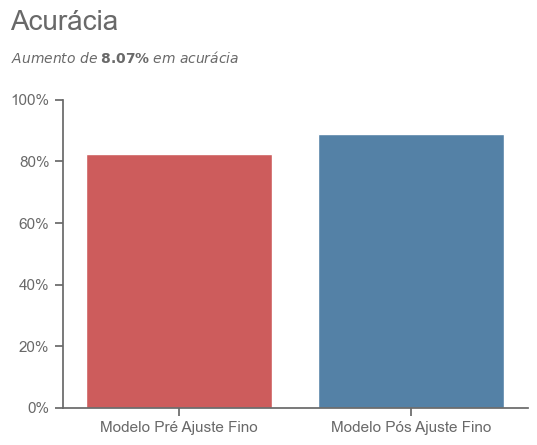

In [86]:
plt.figure(figsize = (6,4))
ax = sns.barplot(df_graficos_modelos, x = 'Modelos', y = 'Acurácia', color = 'steelblue')
ax.set_title('Acurácia', fontsize=20, x=0.003, y=1.2, color="#696969")  # dimgrey
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.patches[0].set_facecolor('indianred')
ax.set_ylim(0, 100)
ax.set_ylabel("")
ax.set_xlabel("")

aumento_acc = 8.07

subtitle_text = rf"${{Aumento\ de}}$ " + \
               fr"${{\bf{aumento_acc}\%}}$ " + \
               r"${{em\ acurácia}}$"

ax.text(0.135, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))

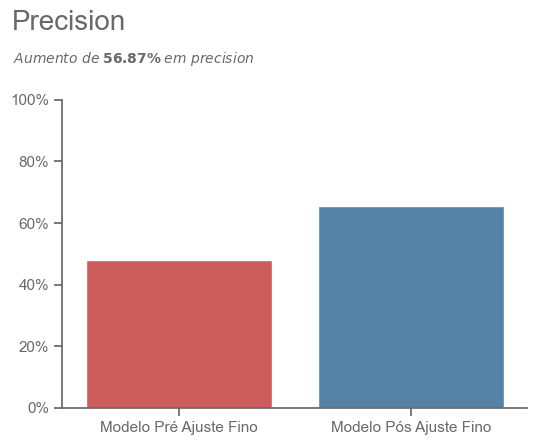

In [87]:
plt.figure(figsize = (6,4))
ax = sns.barplot(df_graficos_modelos, x = 'Modelos', y = 'Precision', color = 'steelblue')
ax.set_title('Precision', fontsize=20, x=0.015, y=1.2, color="#696969")  # dimgrey
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.patches[0].set_facecolor('indianred')
ax.set_ylim(0, 100)
ax.set_ylabel("")
ax.set_xlabel("")

aumento_pc = 56.87

subtitle_text = rf"${{Aumento\ de}}$ " + \
               fr"${{\bf{aumento_pc}\%}}$ " + \
               r"${{em\ precision}}$"

ax.text(0.153, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))

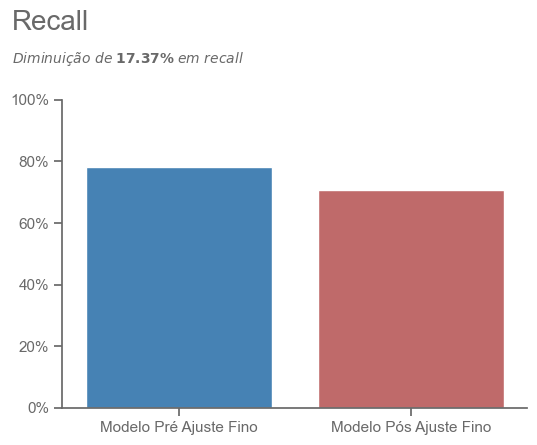

In [88]:
plt.figure(figsize = (6,4))
ax = sns.barplot(df_graficos_modelos, x = 'Modelos', y = 'Recall', color = 'indianred')
ax.set_title('Recall', fontsize=20, x=-0.025, y=1.2, color="#696969")  # dimgrey
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.patches[0].set_facecolor('steelblue')
ax.set_ylim(0, 100)
ax.set_ylabel("")
ax.set_xlabel("")

aumento_pc = 17.37 

subtitle_text = rf"${{Diminuição\ de}}$ " + \
               fr"${{\bf{aumento_pc}\%}}$ " + \
               r"${{em\ recall}}$"

ax.text(0.142, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))

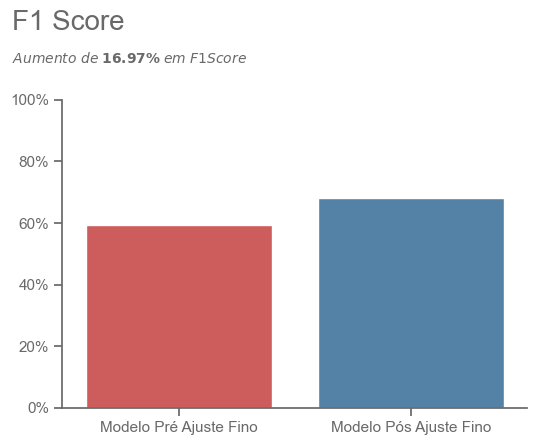

In [89]:
plt.figure(figsize = (6,4))
ax = sns.barplot(df_graficos_modelos, x = 'Modelos', y = 'F1 Score', color = 'steelblue')
ax.set_title('F1 Score', fontsize=20, x=0.013, y=1.2, color="#696969")  # dimgrey
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.patches[0].set_facecolor('indianred')
ax.set_ylim(0, 100)
ax.set_ylabel("")
ax.set_xlabel("")

aumento_acc = 16.97

subtitle_text = rf"${{Aumento\ de}}$ " + \
               fr"${{\bf{aumento_acc}\%}}$ " + \
               r"${{em\ F1 Score}}$"

ax.text(0.145, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))